## relevancerag RAG(relevance check) vs Elephant RAG vs Multi Agent RAG
gpt-4o-mini -> gpt-4o

In [1]:
import os
import getpass
import json
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")

from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid
from langchain_teddynote import logging

from graph_relevancerag import RelevanceRAG
from graph_elephantrag import ElephantRAG
from graph_multiagentrag import MultiAgentRAG

import sys
sys.path.append("../../")
from metrics.metric_eval import evaluate_all_metrics
from utils import load_question

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 한글 폰트 경로 설정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghckd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
# 프로젝트 이름을 입력합니다.
logging.langsmith("Elephant-RAG-vs-Multi-Agent-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
Elephant-RAG-vs-Multi-Agent-RAG


## Eval

In [4]:
question_list = load_question(question_path="../../config/questions/250115-SY-question.yaml")

In [5]:
print(question_list[0])


Below are instructions for filling out items by referring to the examples.
The values shown to the right of the colon (":") are examples;
please delete them after reviewing and rewrite them with the values found in the PDF.
If any item is not mentioned in the PDF, do not remove it—write "None."

[
    {
        "CAM (Cathode Active Material)": {
            "Stoichiometry information": {
                "NCM-622": {
                    "Li ratio": "1",
                    "Ni ratio": "0.6",
                    "Co ratio": "0.2",
                    "Mn ratio": "0.2",
                    "O ratio": "2"
                },
                "ZrO2-NCM-622 (Z622)": {
                    "Li ratio": "0.98",
                    "Ni ratio": "0.6",
                    "Co ratio": "0.2",
                    "Mn ratio": "0.2",
                    "O ratio": "2"
                }
            },
            "Whether or not commercial NCM was used for each sample (Stoichiometry information in order)"

In [6]:
original_question = {
    "input": {"question": question_list[0]}, 
    "config": RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
}

multiagent_question = {
                "messages": [
                    HumanMessage(
                        content="""Please fill out the following JSON structure by referring to the PDF. Verify accurate values for each field, replacing the placeholders. If the information is not mentioned in the PDF, write "None".

[
    {
        "CAM (Cathode Active Material)": {
            "Stoichiometry information": {
                "": {
                    
                }
            },
            "Whether or not commercial NCM was used for each sample (Stoichiometry information in order)": [

            ],
            "Lithium source": ,
            "Synthesis method": ,
            "Describe the crystallization method, such as Hydrothermal, Sintering, or any other technique used during the process.": ,
            "What is the Crystallization final temperature in degree of Celcius used in the process? (e.g., calcination or sintering) mentioned for the crystallization stage.": ,
            "What is the time duration for the final crystallization process, including any calcination or sintering stages? Specify the hours.": ,
            "Doping": ,
            "Coating": ,
            "Additional treatment": 
        }
    }
]

""",
                        name="Researcher"  # Ensure the name is valid, here "Researcher" is used
                    )
                ]
            }, {"recursion_limit": 30}

In [ ]:
import time

def get_rag_instance(file_folder, file_number, model_name, agent_class):
    """
    RAG 클래스를 동적으로 받아서 인스턴스를 생성하는 함수
    :param file_folder: 논문 파일이 위치한 폴더 경로
    :param file_number: 처리할 논문 번호
    :param agent_class: RAG 모델 클래스 (예: MultiAgentRAG)
    :return: 생성된 RAG 모델 인스턴스
    """
    return agent_class(file_folder=file_folder, file_number=file_number, model_name=model_name)

def eval_df_generator(
    data_folder="./data",           ## input 논문이 있는 폴더 위치
    file_num_list=[11],             ## 아직 8번 논문 안됨
    question_number=1,              ## question 번호 1,2,3,4 중 하나
    agent_class=MultiAgentRAG,      ## graph 클래스
    model_name="gpt-4o-mini",
    question=None                   ## 질문 내용 (None일 경우 질문 내용 없음)
):
    # 결과를 저장할 데이터프레임 생성
    eval_df = pd.DataFrame(columns=["paper_number", "question", "ground_truth", "answer", "context"])
    category_names = ["CAM (Cathode Active Material)", "Electrode (only for coin-cell (half-cell))", "Morphological results", "Cathode Performance"]
    
    # 각 논문에 대해 반복
    for i, file_number in enumerate(file_num_list):
        print(f"#####   {file_number}번째 논문    #####")
        
        # RAG 모델 인스턴스 생성
        voltai_graph = get_rag_instance(file_folder=f"{data_folder}/input_data/", file_number=file_number, model_name=model_name, agent_class=agent_class).graph
        
        # 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
        if isinstance(question, dict):
            result = voltai_graph.invoke(**question)
        else:
            result = voltai_graph.invoke(*question)
        
        ## ground truth 불러오기
        # 파일 이름 생성 (파일 번호에 따라 형식 다름)
        if file_number < 10:
            file_name = f"paper_00{file_number}"
        elif file_number < 100:
            file_name = f"paper_0{file_number}"
        else:
            file_name = f"paper_{file_number}"
    
        # JSON 형식의 ground truth 파일 읽기
        with open(f"{data_folder}/ground_truth/{file_name}_gt.json", "r", encoding="utf-8") as file:
            gt = json.load(file)

        # 데이터프레임에 값 저장
        eval_df.loc[i, "paper_number"] = file_number
        
        # 결과에서 해당 카테고리의 답을 추출하여 저장
        if result.get("answer"):
            eval_df.loc[i, "answer"] = [result["answer"][0][category_names[question_number-1]]]
        elif result.get("discussion"):
            eval_df.loc[i, "answer"] = [result["discussion"][category_names[question_number-1]]]
        elif result.get("messages"):
            eval_df.loc[i, "answer"] = [result["messages"][-1][category_names[question_number-1]]]
        
        # ground truth를 데이터프레임에 저장
        eval_df.loc[i, "ground_truth"] = [gt[category_names[question_number-1]]]
        time.sleep(60)
    return eval_df

In [8]:
file_num_list = [8, 11, 16, 22, 33, 35, 39, 56]
question_number = 1

In [9]:
print("##       Relevance RAG Method")
# relevancerag_df = eval_df_generator(
    # data_folder="../../data", 
    # file_num_list=file_num_list, 
    # question_number=1, 
    # agent_class=RelevanceRAG, 
    # model_name="gpt-4o"
    # question=original_question
    # )
# relevancerag_df.to_csv("relevancerag_df_mini_k10.csv", index=False, encoding="utf-8-sig")
relevancerag_df = pd.read_csv("relevancerag_df_k10.csv")

##       Relevance RAG Method


In [10]:
relevancerag_df

,paper_number,question,ground_truth,answer,context
0,8,NaN,[{'Stoichiometry information': {'NCM111': {'Li...,[{'Stoichiometry information': {'NCM-622': {'L...,NaN
1,11,NaN,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM-111': {'L...,NaN
2,16,NaN,[{'Stoichiometry information': {'LiNi1/3Co1/3M...,[{'Stoichiometry information': {'NCM-622': {'L...,NaN
3,22,NaN,[{'Stoichiometry information': {'LiNi0.84Co0.1...,[{'Stoichiometry information': {'NCM-622': {'L...,NaN
4,33,NaN,[{'Stoichiometry information': {'NCM701515': {...,[{'Stoichiometry information': {'NCM701515': {...,NaN
5,35,NaN,[{'Stoichiometry information': {'LiNi0.85Co0.1...,[{'Stoichiometry information': {'LiNi0.85Co0.1...,NaN
6,39,NaN,[{'Stoichiometry information': {'LiNi0.92Co0.0...,[{'Stoichiometry information': {'N92': {'Li ra...,NaN
7,56,NaN,[{'Stoichiometry information': {'Li[Ni0.8Co0.1...,[{'Stoichiometry information': {'NCM-811': {'L...,NaN


In [ ]:
print("##       Elephant RAG Method")
# elephantrag_df = eval_df_generator(
#     data_folder="../../data", 
#     file_num_list=file_num_list, 
#     question_number=1, 
#     agent_class=ElephantRAG, 
#     model_name="gpt-4o",
#     question=original_question
# )
# elephantrag_df.to_csv("./graph-result/elephantrag_df_k10.csv", index=False, encoding="utf-8-sig")
elephantrag_df = pd.read_csv("./graph-result/elephantrag_df_k10.csv")

##       Elephant RAG Method
#####   8번째 논문    #####
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
#####   11번째 논문    #####
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
#####   16번째 논문    #####
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
#####   22번째 논문    #####
        RELEVANCE CHECK for ANSWER 2 : yes
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        Success Discussion!
#####   33번째 논문    #####
        RELEVANCE CHECK for ANSWER 1 : yes
        RELEVANCE CHECK for ANSWER 3 : yes
        RELEVANCE CHECK for ANSWER 2 : yes
        Success Discussion!
#####   35번째 논문    #####
        RELEVANCE CHECK for ANSWER 1 

In [46]:
print("##       Multi Agent RAG Method")
multiagentrag_df = eval_df_generator(
    data_folder="../../data", 
    file_num_list=file_num_list, 
    question_number=1, 
    agent_class=MultiAgentRAG, 
    model_name="gpt-4o",
    question=multiagent_question
)
multiagentrag_df.to_csv("./graph-result/multiagentrag_df_k10.csv", index=False, encoding="utf-8-sig")
multiagentrag_df = pd.read_csv("./graph-result/multiagentrag_df_k10.csv")

##       Multi Agent RAG Method
#####   8번째 논문    #####
#####   11번째 논문    #####
#####   16번째 논문    #####
#####   22번째 논문    #####
#####   33번째 논문    #####
#####   35번째 논문    #####
#####   39번째 논문    #####
#####   56번째 논문    #####


#### sentence 만들기

In [157]:
class Evaluator:
    def __init__(self):
        # 평가 지표 컬럼 정의: BLEU, METEOR, Semantic Similarity, 그리고 다양한 ROUGE 점수 포함
        self.metric_columns = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']
        
    def eval(self, eval_frame: pd.DataFrame, mode: str = "sentence-template"):
        """
        평가를 수행하는 함수. 
        eval_frame: 평가 대상 데이터 프레임
        mode: 평가 모드, 기본값은 "sentence-template" (현재 유일한 지원 모드)
        """
        if mode == "sentence-template":
            # ground_truth와 answer 열의 값을 기반으로 문장 생성
            eval_frame["ground_truth_sentence"] = eval_frame["ground_truth"].apply(
                lambda x: self.eval_sentence_generator(1, list(ast.literal_eval(x)[0].values()))
            )
            eval_frame["answer_sentence"] = eval_frame["answer"].apply(
                lambda x: self.eval_sentence_generator(1, list(ast.literal_eval(x)[0].values()))
            )

            # 평가 메트릭 계산 (BLEU, METEOR, STS 등 모든 메트릭 포함)
            metric_df = eval_frame[["ground_truth_sentence", "answer_sentence"]].apply(
                lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["answer_sentence"]), 
                axis=1
            ).apply(pd.Series)  # 결과를 Series로 변환하여 데이터 프레임으로 만듦

            # ROUGE 메트릭 분리 (ROUGE는 딕셔너리 형태이므로 열로 분리 필요)
            rouge_df = metric_df["ROUGE"].apply(pd.Series)

            # 최종 평가 데이터 프레임 생성
            eval_df = pd.concat([
                eval_frame,                # 기존 평가 데이터
                metric_df.drop(columns=["ROUGE"]),  # ROUGE 외 다른 메트릭 추가
                rouge_df                   # ROUGE 메트릭 추가
            ], axis=1)

            return eval_df
    
    def eval_sentence_generator(self, question_number, values):
        """
        주어진 question_number와 values를 바탕으로 평가 문장을 생성하는 함수.
        question_number: 질문 번호
        values: 문장에 포함될 값들의 리스트
        """
        if question_number == 1:
            # 첫 번째 질문 템플릿에 따라 문장 생성
            return f"The {values[0]} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating and {values[9]} treatment."
        elif question_number == 2:
            # 두 번째 질문 템플릿에 따라 문장 생성
            return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]} for {values[4]}."

In [158]:
evaluation = Evaluator()
relevancerag_eval_df = evaluation.eval(eval_frame=relevancerag_df)
print("success relevance rag evaluation df")
elephantrag_eval_df = evaluation.eval(eval_frame=elephantrag_df)
print("success elephant rag evaluation df")
multiagentrag_eval_df = evaluation.eval(eval_frame=multiagentrag_df)
print("success multi agent rag evaluation df")

success relevance rag evaluation df
success elephant rag evaluation df
success multi agent rag evaluation df


### 시각화

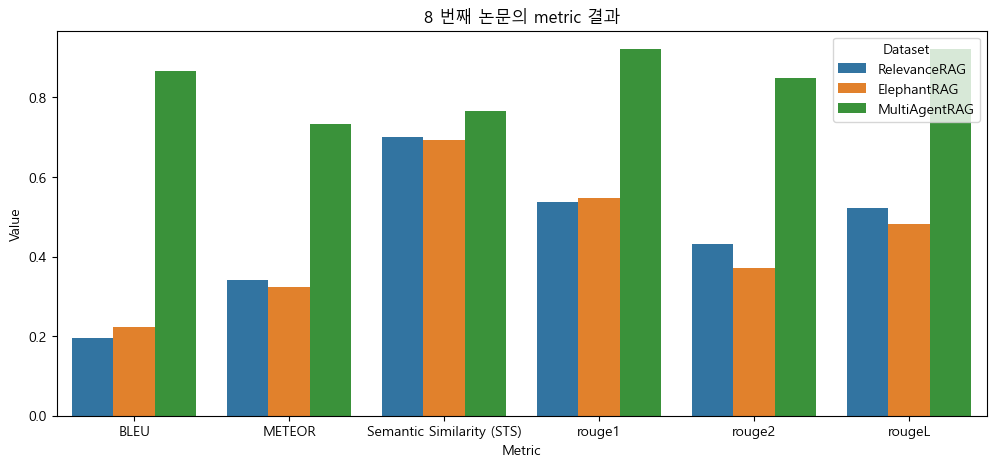

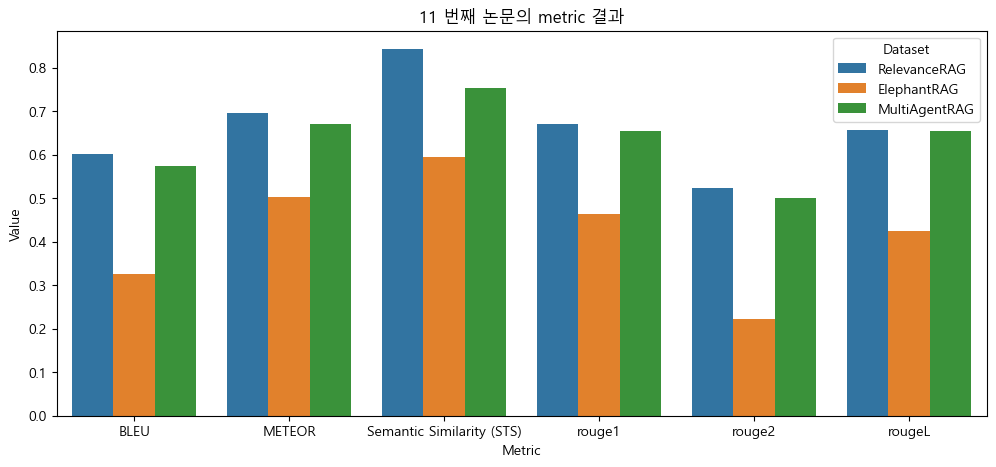

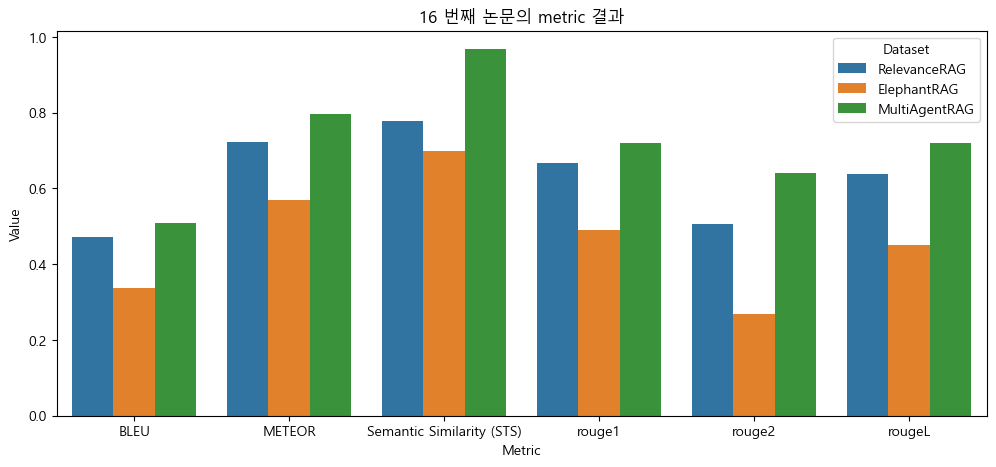

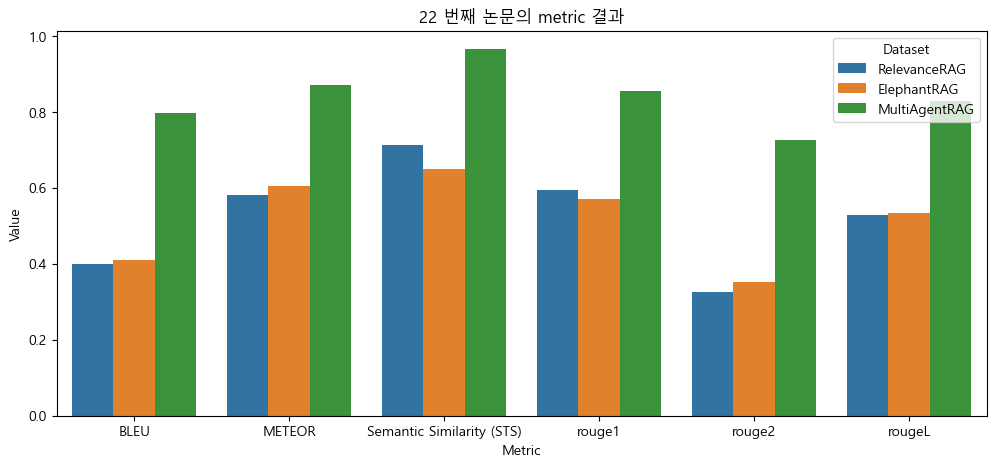

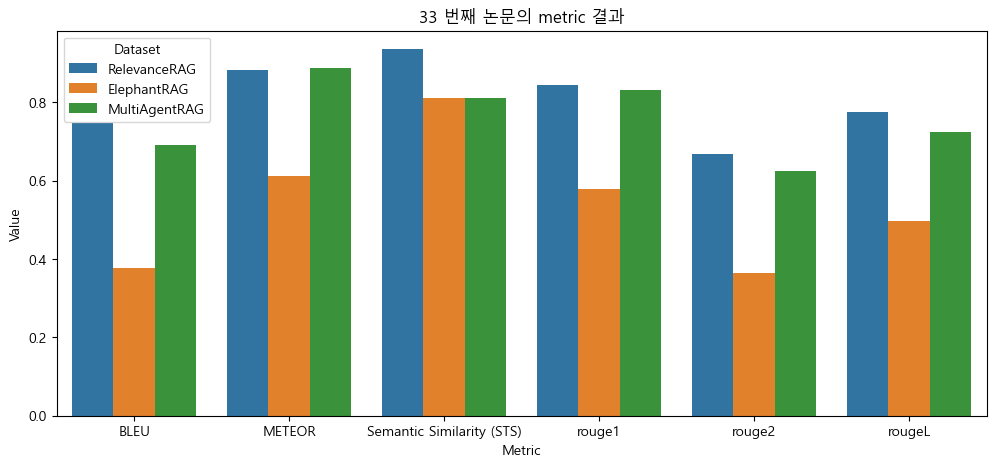

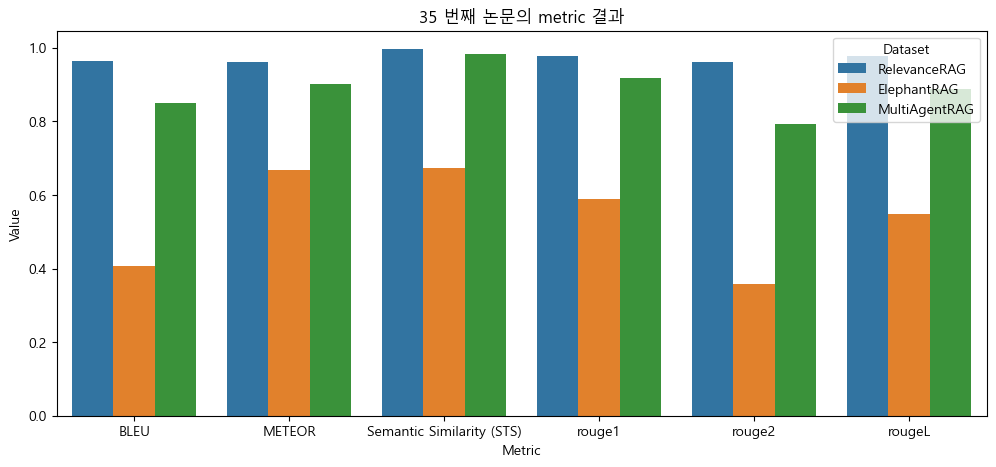

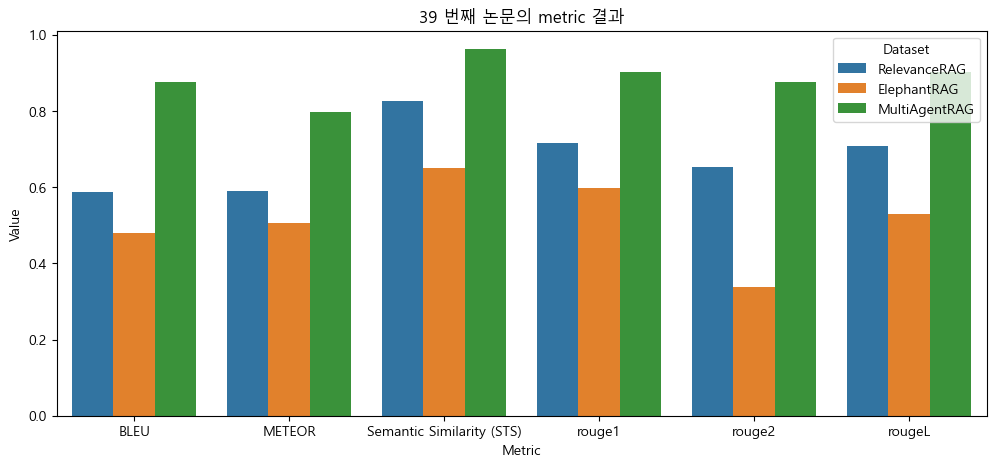

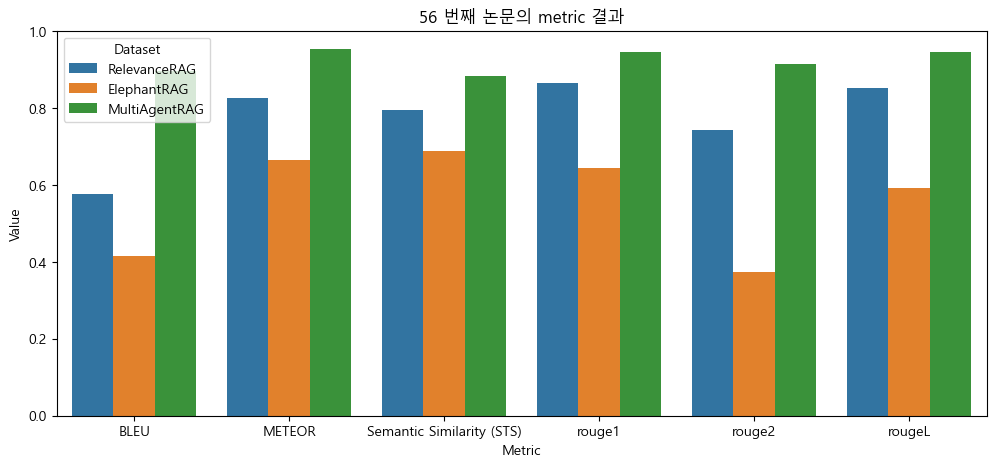

In [149]:
metric_columns = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']

for num in file_num_list:
    plt.figure(figsize=(12,5))
    relevancerag_temp_df = relevancerag_eval_df[relevancerag_eval_df["paper_number"] == num][metric_columns]
    relevancerag_temp_df = relevancerag_temp_df.melt(var_name="Metric", value_name="Value")
    relevancerag_temp_df["Dataset"] = "RelevanceRAG"

    elephantrag_temp_df = elephantrag_eval_df[elephantrag_eval_df["paper_number"] == num][metric_columns]
    elephantrag_temp_df = elephantrag_temp_df.melt(var_name="Metric", value_name="Value")
    elephantrag_temp_df["Dataset"] = "ElephantRAG"

    multiagentrag_temp_df = multiagentrag_eval_df[multiagentrag_eval_df["paper_number"] == num][metric_columns]
    multiagentrag_temp_df = multiagentrag_temp_df.melt(var_name="Metric", value_name="Value")
    multiagentrag_temp_df["Dataset"] = "MultiAgentRAG"    

    combined_df = pd.concat([relevancerag_temp_df, elephantrag_temp_df, multiagentrag_temp_df])    
    
    sns.barplot(data=combined_df, x="Metric", y="Value", hue="Dataset")
    plt.title(f"{num} 번째 논문의 metric 결과")
    plt.show()

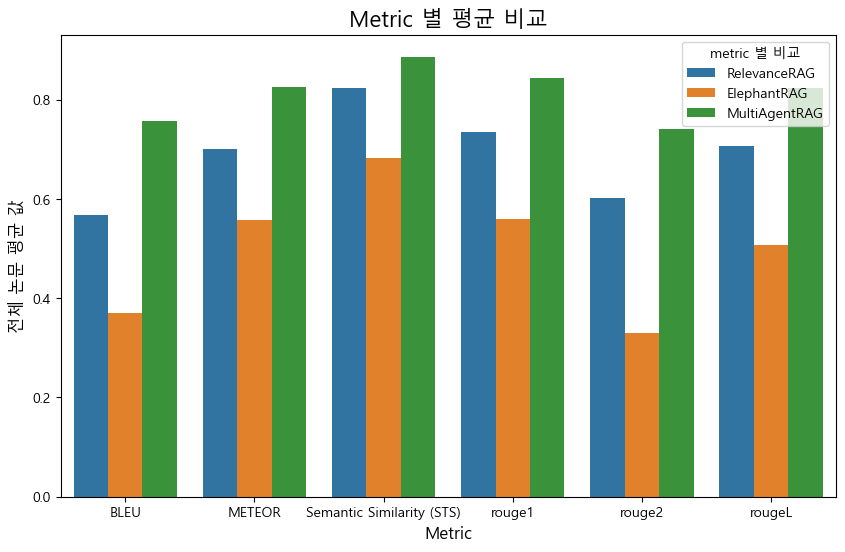

In [150]:
# `metric` 별 평균 값 계산
relevancerag_mean = relevancerag_eval_df[metric_columns].mean().reset_index()
relevancerag_mean.columns = ["Metric", "Value"]
relevancerag_mean["Dataset"] = "RelevanceRAG"

elephantrag_mean = elephantrag_eval_df[metric_columns].mean().reset_index()
elephantrag_mean.columns = ["Metric", "Value"]
elephantrag_mean["Dataset"] = "ElephantRAG"

multiagentrag_mean = multiagentrag_eval_df[metric_columns].mean().reset_index()
multiagentrag_mean.columns = ["Metric", "Value"]
multiagentrag_mean["Dataset"] = "MultiAgentRAG"

# 데이터 결합
combined_mean = pd.concat([relevancerag_mean, elephantrag_mean, multiagentrag_mean])

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_mean, x="Metric", y="Value", hue="Dataset", dodge=True)

# 플롯 제목 및 레이블 설정
plt.title("Metric 별 평균 비교", fontsize=16)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("전체 논문 평균 값", fontsize=12)
plt.legend(title="metric 별 비교", fontsize=10)
plt.show()

In [155]:
import pprint
pprint.pprint(ast.literal_eval(multiagentrag_eval_df["ground_truth"][0])[0], sort_dicts=False)

{'Additional treatment': 'None',
 'Coating': 'None',
 'Describe the crystallization method, such as Hydrothermal, Sintering, or any other technique used during the process.': 'None',
 'Doping': 'None',
 'Lithium source': 'None',
 'Stoichiometry information': {'NCM111': {'Co ratio': '0.33',
                                          'Li ratio': '1',
                                          'Mn ratio': '0.33',
                                          'Ni ratio': '0.33',
                                          'O ratio': '2'},
                               'NCM523': {'Co ratio': '0.2',
                                          'Li ratio': '1',
                                          'Mn ratio': '0.3',
                                          'Ni ratio': '0.5',
                                          'O ratio': '2'},
                               'NCM622': {'Co ratio': '0.2',
                                          'Li ratio': '1',
                                          'Mn 

In [156]:
pprint.pprint(ast.literal_eval(multiagentrag_eval_df["answer"][0])[0], sort_dicts=False)

{'Additional treatment': 'None',
 'Coating': 'None',
 'Describe the crystallization method, such as Hydrothermal, Sintering, or any other technique used during the process.': 'Hydrothermal',
 'Doping': 'None',
 'Lithium source': 'LiOH',
 'Stoichiometry information': {'NCM111': {'Co ratio': '0.33',
                                          'Li ratio': '1.02',
                                          'Mn ratio': '0.33',
                                          'Ni ratio': '0.33',
                                          'O ratio': '2'},
                               'NCM523': {'Co ratio': '0.2',
                                          'Li ratio': '1.02',
                                          'Mn ratio': '0.3',
                                          'Ni ratio': '0.5',
                                          'O ratio': '2'},
                               'NCM622': {'Co ratio': '0.2',
                                          'Li ratio': '1.02',
                             